# Notebook for demo how to get features with [neuron_morphology](https://github.com/AllenInstitute/neuron_morphology)

To obtain the package, please see [https://neuron-morphology.readthedocs.io/en/readthedocs/](https://neuron-morphology.readthedocs.io/en/readthedocs/).

This step-by-step guid will walk you through the whole process of getting the interested features with neuron_morphology.


In [1]:
import sys
sys.path.insert(0, "../")

from io import StringIO
import copy
import matplotlib.pyplot as plt

import neuron_morphology.swc_io as swcio
from neuron_morphology.morphology import Morphology
from neuron_morphology.swc_io import morphology_from_swc
from neuron_morphology.feature_extractor.data import Data
from neuron_morphology.feature_extractor.feature_extractor import FeatureExtractor
from neuron_morphology.features.default_features import default_features
from neuron_morphology.features.dimension import dimension
from neuron_morphology.features.soma import calculate_number_of_stems
from neuron_morphology.features.path import max_path_distance
from neuron_morphology.constants import (
    SOMA, AXON, BASAL_DENDRITE, APICAL_DENDRITE
)

import json
import numpy as np
import neuron_morphology.feature_extractor.feature_writer as fw

## Pick your neuron (.swc/.csv)

Here select one SWC file as an example.

In [2]:
fmost_swc_file = "../tests/data/17545-6151-X24259-Y36270.swc"

## Ensure one SWC with only one soma point

This is developed for current registered fMOST SWC file. It will adjusted and added as a module into neuron_morphology later.

In [3]:
def prepare_neuron_tree(swc_data):
    nodes = swc_data.to_dict('record')

    replace_type = 2 # default node type
    for node in nodes:
        node['parent'] = int(node['parent'])
        node['id'] = int(node['id'])
        node['type'] = int(node['type'])

        if node['parent'] == -1 and node['type'] != 1:
            replace_type = node['type']

        if node['type'] == 1 and node['parent'] != -1:
            node['type'] = replace_type

    soma_list = []
    for node in nodes:
        if node['type'] == 1:
            soma_list.append(node)

    # create a new soma point
    if len(soma_list) > 1:
        x = 0
        y = 0
        z = 0
        n = len(soma_list)
        for node in soma_list:
            x += node['x']
            y += node['y']
            z += node['z']

        soma = copy.deepcopy(soma_list[0])
        soma['id'] = nodes[-1]['id']
        soma['x'] = x/n
        soma['y'] = y/n
        soma['z'] = z/n
        nodes.append(soma)

        for node in soma_list:
            node['parent'] = soma['id']
            node['type'] = replace_type
    
    return nodes

## Load SWC file as morphology data

We can load the SWC file into our morphology data object and then calculate features on it.

Text(0.5, 1.0, 'z-y view')

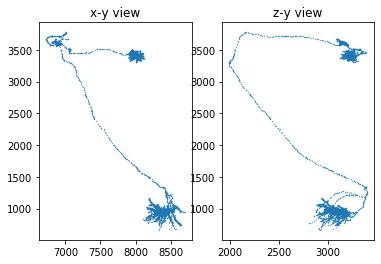

In [4]:
# load
swc_data = swcio.read_swc(fmost_swc_file)

nodes = prepare_neuron_tree(swc_data)
test_data = Data(Morphology(nodes, node_id_cb=lambda node: node['id'], parent_id_cb=lambda node: node['parent']))

# visualize
x = [node['x'] for node in nodes]
y = [node['y'] for node in nodes]
z = [node['z'] for node in nodes]

fig, ax = plt.subplots(1, 2)
ax[0].scatter(x, y, s=0.1)
ax[0].set_title('x-y view')
ax[1].scatter(z, y, s=0.1)
ax[1].set_title('z-y view')

## Define interested features set

For fMOST neuron analysis, we are interested in the following features:

```
Number of Stems: (Dendrite)
Overall Width: (Dendrite and Axon)
Overall Height: (Dendrite and Axon)
Overall Depth: (Dendrite and Axon)
Total Length: (Dendrite and Axon)
MaxEuclidean Distance: (Dendrite, Axon, Local Axon?)
Max Path Distance: (Dendrite and Axon)
Number of Branches: (Dendrite, Axon, Local Axon?)
Max Branch Order: (Dendrite)
Depth-Width Ratio: (Dendrite)
```


In [5]:
fe = FeatureExtractor()

for feature in default_features:
    fe.register_features([feature])

### Extracting features

In [6]:
feature_extraction_run = fe.extract(test_data)
default_features = feature_extraction_run.results

axon_dimension_features = dimension(test_data, [AXON])
dendrite_dimension_features = dimension(test_data, [BASAL_DENDRITE])

num_stems = calculate_number_of_stems(test_data,[BASAL_DENDRITE])

dendrite_max_path_dist = max_path_distance(test_data, [BASAL_DENDRITE]) + max_path_distance(test_data, [APICAL_DENDRITE])
axon_max_path_dist = max_path_distance(test_data, [AXON])


2020-02-24 17:53:01,732 root         INFO     skipping mark (validation failed): type
2020-02-24 17:53:01,735 root         INFO     skipping mark (validation failed): type
2020-02-24 17:53:01,737 root         INFO     skipping mark (validation failed): type
../neuron_morphology/feature_extractor/mark.py:118: UserWarning: This morphology is not uniquely rooted! Found 279 root nodes. Features using the root node of this morphology may not select that node consistently. Some or all of these root nodes may not be soma nodes.
  f"This morphology is not uniquely rooted! Found {num_roots} "
2020-02-24 17:53:01,753 root         INFO     selected marks: <bound method FeatureExtractionRun.select_marks of <neuron_morphology.feature_extractor.feature_extraction_run.FeatureExtractionRun object at 0x7f67cc6575c0>>
2020-02-24 17:53:01,756 root         INFO     skipping feature: apical_dendrite.bifurcation.dimension. Found extra marks: ['RequiresApical']
2020-02-24 17:53:01,758 root         INFO     s

2020-02-24 17:53:01,842 root         INFO     skipping feature: basal_dendrite.basal_dendrite.earth_movers_distance. Found extra marks: ['RequiresReferenceLayerDepths', 'RequiresLayeredPointDepths']
2020-02-24 17:53:01,843 root         INFO     skipping feature: axon.basal_dendrite.earth_movers_distance. Found extra marks: ['RequiresReferenceLayerDepths', 'RequiresLayeredPointDepths']
2020-02-24 17:53:01,845 root         INFO     selected features: ['dendrite.bifurcation.dimension', 'basal_dendrite.bifurcation.dimension', 'all_neurites.bifurcation.dimension', 'axon.bifurcation.dimension', 'dendrite.node.dimension', 'basal_dendrite.node.dimension', 'all_neurites.node.dimension', 'axon.node.dimension', 'dendrite.tip.dimension', 'basal_dendrite.tip.dimension', 'all_neurites.tip.dimension', 'axon.tip.dimension', 'dendrite.compartment.dimension', 'basal_dendrite.compartment.dimension', 'all_neurites.compartment.dimension', 'axon.compartment.dimension', 'dendrite.num_nodes', 'basal_dendrite.

## Results

##### We can print extracted features

In [7]:
output_features = {}
    
output_features['Number_of_Stems'] = {}
output_features['Overall_Width'] = {}
output_features['Overall_Height'] = {}
output_features['Overall_Depth'] = {}
output_features['Total_Length'] = {}
output_features['Max_Euclidean_Distance'] = {}
output_features['Max_Path_Distance'] = {}
output_features['Number_of_Branches'] = {}
output_features['Max_Branch_Order'] = {}
output_features['Depth_Width_Ratio'] = {}

output_features['Number_of_Stems']['Dendrite'] = default_features['dendrite.num_branches']
output_features['Overall_Width']['Dendrite'] = "{0:.2f}".format(dendrite_dimension_features['width'])
output_features['Overall_Height']['Dendrite'] = "{0:.2f}".format(dendrite_dimension_features['height'])
output_features['Overall_Depth']['Dendrite'] = "{0:.2f}".format(dendrite_dimension_features['depth'])
output_features['Total_Length']['Dendrite'] = default_features['dendrite.total_length']
output_features['Max_Euclidean_Distance']['Dendrite'] = "{0:.2f}".format(default_features['dendrite.max_euclidean_distance'])
output_features['Max_Path_Distance']['Dendrite'] = "{0:.2f}".format(dendrite_max_path_dist)
output_features['Number_of_Branches']['Dendrite'] = default_features['dendrite.num_branches']
output_features['Max_Branch_Order']['Dendrite'] = default_features['dendrite.max_branch_order']
output_features['Depth_Width_Ratio']['Dendrite'] = "{0:.2f}".format(dendrite_dimension_features['depth']/dendrite_dimension_features['width'])

output_features['Overall_Width']['Axon'] = "{0:.2f}".format(axon_dimension_features['width'])
output_features['Overall_Height']['Axon'] = "{0:.2f}".format(axon_dimension_features['height'])
output_features['Overall_Depth']['Axon'] = "{0:.2f}".format(axon_dimension_features['depth'])
output_features['Total_Length']['Axon'] = default_features['axon.total_length']
output_features['Max_Euclidean_Distance']['Axon'] = "{0:.2f}".format(default_features['axon.max_euclidean_distance'])
output_features['Max_Path_Distance']['Axon'] = "{0:.2f}".format(axon_max_path_dist)
output_features['Number_of_Branches']['Axon'] = default_features['axon.num_branches']


output = json.dumps(output_features, indent=2)

print(output)

{
  "Number_of_Stems": {
    "Dendrite": 120
  },
  "Overall_Width": {
    "Dendrite": "222.43",
    "Axon": "1967.18"
  },
  "Overall_Height": {
    "Dendrite": "201.60",
    "Axon": "3112.88"
  },
  "Overall_Depth": {
    "Dendrite": "196.78",
    "Axon": "1416.83"
  },
  "Total_Length": {
    "Dendrite": 5783.405108413997,
    "Axon": 22977.13501045168
  },
  "Max_Euclidean_Distance": {
    "Dendrite": "1211.80",
    "Axon": "3361.32"
  },
  "Max_Path_Distance": {
    "Dendrite": "0.00",
    "Axon": "21.37"
  },
  "Number_of_Branches": {
    "Dendrite": 120,
    "Axon": 179
  },
  "Max_Branch_Order": {
    "Dendrite": 0
  },
  "Depth_Width_Ratio": {
    "Dendrite": "0.88"
  }
}


##### Or save the features as h5 or csv file

In [8]:
heavy_path = "test_features.h5"
table_path = "test_features.csv"

features_writer = fw.FeatureWriter(heavy_path, table_path)
features_writer.add_run("test", feature_extraction_run.serialize())
features_writer.write_table()

../neuron_morphology/feature_extractor/feature_writer.py:54: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  self.heavy_file = h5py.File(self.heavy_path, driver="core")
2020-02-24 17:53:10,806 root         WARNING  writing additional outputs to csv. See output json for record of selected features and marks
